Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

# 1. Import

In [3]:
import pandas as pd
# import seaborn as sns
import numpy as np
import pathlib
import pickle
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
from sklearn import metrics
import csv

import PyQt5

# 2. Import Files

## 2.1 Save csv files as pickle

Only run this once to save our csv data as pickle files

In [5]:
# --> NO NEED TO RUN SAVED AS PICKLE FILES <--
# WEATHER FILES ##

# # AZ PHX Sky Harbor Data #
AZW_15 = pd.read_csv("./Data/AZW_15.csv")

# # ENVIMET DATA #
BPS = []
Fname = []
for path in pathlib.Path("./Data/BPS").iterdir():
    if path.is_file():
        current_file = pd.read_csv(path)
        BPS.append(current_file)
        Fname.append(path.name.replace('.csv', ''))

# # CAMPUS METABOLISM DATA #
metabol14 = []
for path in pathlib.Path('./Data/metabol14').iterdir():
    if path.is_file():
        current_file = pd.read_csv(path)
        metabol14.append(current_file)

# ## Drop last row of EnviMet Data
for i in range(len(BPS)):
    BPS[i] = BPS[i].drop(16)

# ## Save files as pickle
AZW_15.to_pickle("./Data/AZW_15.pkl")

with open('./Data/BPS.pkl', 'wb') as f:
    pickle.dump(BPS, f)

with open('./Data/Fname.pkl', 'wb') as f:
    pickle.dump(Fname, f)

with open('./Data/metabol14.pkl', 'wb') as f:
    pickle.dump(metabol14, f)

## 2.2 Reload Pickle

In [7]:
# We will convert these to df depending on the building we choose
# 2. Load 14 envimet bldgData (14 filtered buildings)
with open('./Data/BPS.pkl', 'rb') as f:
    envi14 = pickle.load(f)

# 3. Load names of BPS files
with open('./Data/Fname.pkl', 'rb') as f:
    Fname = pickle.load(f)

# 4. Load 14 campus metabolism building energy data
with open('./Data/metabol14.pkl', 'rb') as f:
    metabol14 = pickle.load(f)

## 2.3 Choose building name to import

In [8]:
##Print Building Names ##
for i in range(len(Fname)):
    print(Fname[i])
    
bldname = input('Enter building name: ')

for i in range(len(envi14)):
    if bldname == Fname[i]:
        # save 
        envi_bldg = envi14[i]

if bldname not in Fname:
    print("\x1b[31m\"Please enter a valid name from the list above\"\x1b[0m")


Goldwater
Best Hall
COD North
Bio Design Institute B
University Club
Engineering Research Ctr
ISTB 2
Interdisciplinary AB
Health Services
ISTB 5
ISTB 1
Lifescience A_B_D
Bio Design Institute A
ISTB 4
Enter building name: ISTB 1


## 2.4 Create Data Frame

In [9]:
class building:
    
    def __init__(self, bldgname):
        self.bldgname = bldgname
    
    def campusmetabolism(self):
        for i in range(len(metabol14)):
            if metabol14[i]['bldgname'][0] == bldname:
                cmp = metabol14[i]
            elif (metabol14[i]['bldgname'][0] == 'ISTB-5'):
                cmp = metabol14[i]
        return cmp
    
    def envimet(self):
        env = envi_bldg[['Date', 'Time', 'AirTempInFrontOfAllFacades_MEAN', 'RelativeAirHumidityInFrontOfAllFacades_MEAN',
                     'WindSpeedInFrontOfAllFacades_MEAN']]
        
        env = env.rename(columns = {'AirTempInFrontOfAllFacades_MEAN':'Air Temp',
                                    'RelativeAirHumidityInFrontOfAllFacades_MEAN':'Rel Humid',
                                    'WindSpeedInFrontOfAllFacades_MEAN':'Wind Speed'})
        return env


Bldg = building(bldname)
metabol = Bldg.campusmetabolism() # campus metabolism
envimet = Bldg.envimet()          # envimet
print(bldname)

ISTB 1


In [11]:
#read csv and convert to pkl, then read pkl below
# AZW_15 = pd.read_csv("./Data/AZW_15.csv")

# DF for AZ Weather Data (15-min)
weather_station = pd.read_pickle('./Data/AZW_15.pkl')



# 3. Preprocessing

## 3.1 Formatting Date and Time

### a) Envimet dates

In [12]:
# 1. format time
envimet['Time'] = envimet['Time'].str.replace('.',':')
envimet['Time'] = envimet['Time'].str.replace('01','00')

# convert to 24 hour format
envimet['Time'] = pd.to_datetime(envimet['Time']).dt.strftime('%H:%M')

# 2. format date (still in string)
envimet['Date'] = pd.to_datetime(envimet['Date']).dt.strftime('%m/%d/%Y')

# 3. combine date time column as string and set as index
envimet['Date_Time'] = envimet['Date'] + ' ' + envimet['Time']

# 4. Get string type for month and time
envimet['Month'] = envimet['Date_Time'].str[0:2]
envimet['Time'] = envimet['Time'].str.replace(':','')

# 5. Rearrange columns
print(list(envimet.columns))
envimet = envimet[['Date_Time','Month','Time', 'Air Temp', 'Rel Humid' ]]

envimet = envimet.set_index('Date_Time')


['Date', 'Time', 'Air Temp', 'Rel Humid', 'Wind Speed', 'Date_Time', 'Month']


/home/biswas/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


In [13]:
# # 5. Get numeric for month hour and minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time)
# microclimate['Month_num'] = microclimate.Date_Time.dt.month
# microclimate['Hour_num'] = microclimate.Date_Time.dt.hour
# microclimate['Minute_num'] = microclimate.Date_Time.dt.minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# # 6. Rearrange columns
# print(list(microclimate.columns))
# microclimate = microclimate[['Date_Time','Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid' ]]

### b) Weather Station dates

In [14]:
# 1. Get string type for month and time
weather_station['Month'] = weather_station['Date_Time'].str[0:2]
weather_station['Time'] = weather_station['Date_Time'].str[11:]
weather_station['Time'] = weather_station['Time'].str.replace(':','')

# 2. Get numeric for month hour and minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time)
weather_station['Month_num'] = weather_station.Date_Time.dt.month
weather_station['Hour_num'] = weather_station.Date_Time.dt.hour
weather_station['Minute_num'] = weather_station.Date_Time.dt.minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# 3. set date time as index
weather_station = weather_station.set_index('Date_Time') 

### c) Building energy dates

In [15]:
metabol.tstamp = pd.to_datetime(metabol.tstamp).dt.strftime('%m/%d/%Y %H:%M')

# remove unwanted columns
metabol = metabol[['tstamp','KW', 'CHWTON']]

# set date time as index
metabol = metabol.set_index('tstamp')

## 3.2 Append Energy Consumption to Weather Station data

In [16]:
weather_station =  pd.concat([metabol, weather_station], axis = 1, join = "inner")

# rearrange column
weather_station = weather_station[['Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid', 'KW','CHWTON' ]]

# weather_station.to_csv('./Data/weather_st_numstr') # save data with string and numeric date format

In [17]:
weather_station.to_csv('./Data/weather_st.csv') # save data with string and numeric date format


In [19]:
#using single layer ANN. Model Parameters: hidden layer- 10 neurons, output layer- 1 neuron
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
print(weather_station.shape)
Y = weather_station['CHWTON']
X = weather_station.drop(labels = ['Month','Time','Month_num', 'Hour_num', 'Minute_num', 'KW','CHWTON'], axis = 1)


#keep only temperature and relative humidity parameter in your dataset
#normalize your data to get values between 0 and 1
# X= X.values.reshape(-1, 2)
Y= Y.values.reshape(-1, 1)
print(X.shape)
# create scaler
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X)
print(X_scaled.shape)
# #do for output variables
scaler2 = StandardScaler()
Y_scaled = scaler2.fit_transform(Y)
X_scaled = np.asarray(X_scaled).astype('float32')
Y_scaled = np.asarray(Y_scaled).astype('float32')
print(Y_scaled.shape)
X_train, X_test, Y_train,Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=20)
model = Sequential()
model.add(Dense(12, input_dim=2, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
# model.summary()
model.compile(loss='mse', optimizer='adam', metrics = ['mse','mae'])
# # fit model
history = model.fit(X_train, Y_train, batch_size=128, epochs=200, verbose=1, validation_split=0.2)


2021-09-14 08:38:31.547162: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/biswas/testing/devel/lib:/home/biswas/catkin_ws/devel/lib:/opt/ros/melodic/lib
2021-09-14 08:38:31.547193: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(34620, 9)
(34620, 2)
(34620, 2)
(34620, 1)
Epoch 1/200


2021-09-14 08:38:32.421275: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-09-14 08:38:32.457281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 08:38:32.458154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce MX130 computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 37.33GiB/s
2021-09-14 08:38:32.458361: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/biswas/testing/devel/lib:/home/biswas/catkin_ws/devel/lib:/opt/ros/melodic/lib
2021-09-14 08:38:32.458534: W

174/174 [==============================] - 0s 1ms/step - loss: 0.6632 - mse: 0.6632 - mae: 0.6883 - val_loss: 0.3806 - val_mse: 0.3806 - val_mae: 0.4913
Epoch 2/200
174/174 [==============================] - 0s 606us/step - loss: 0.2998 - mse: 0.2998 - mae: 0.4307 - val_loss: 0.2523 - val_mse: 0.2523 - val_mae: 0.3977
Epoch 3/200
174/174 [==============================] - 0s 593us/step - loss: 0.2168 - mse: 0.2168 - mae: 0.3669 - val_loss: 0.1899 - val_mse: 0.1899 - val_mae: 0.3453
Epoch 4/200
174/174 [==============================] - 0s 627us/step - loss: 0.1695 - mse: 0.1695 - mae: 0.3251 - val_loss: 0.1513 - val_mse: 0.1513 - val_mae: 0.3099
Epoch 5/200
174/174 [==============================] - 0s 671us/step - loss: 0.1388 - mse: 0.1388 - mae: 0.2959 - val_loss: 0.1263 - val_mse: 0.1263 - val_mae: 0.2838
Epoch 6/200
174/174 [==============================] - 0s 772us/step - loss: 0.1197 - mse: 0.1197 - mae: 0.2751 - val_loss: 0.1104 - val_mse: 0.1104 - val_mae: 0.2650
Epoch 7/200


Epoch 50/200
174/174 [==============================] - 0s 631us/step - loss: 0.0879 - mse: 0.0879 - mae: 0.2263 - val_loss: 0.0851 - val_mse: 0.0851 - val_mae: 0.2250
Epoch 51/200
174/174 [==============================] - 0s 649us/step - loss: 0.0878 - mse: 0.0878 - mae: 0.2268 - val_loss: 0.0855 - val_mse: 0.0855 - val_mae: 0.2265
Epoch 52/200
174/174 [==============================] - 0s 600us/step - loss: 0.0877 - mse: 0.0877 - mae: 0.2268 - val_loss: 0.0853 - val_mse: 0.0853 - val_mae: 0.2255
Epoch 53/200
174/174 [==============================] - 0s 598us/step - loss: 0.0878 - mse: 0.0878 - mae: 0.2266 - val_loss: 0.0851 - val_mse: 0.0851 - val_mae: 0.2243
Epoch 54/200
174/174 [==============================] - 0s 638us/step - loss: 0.0878 - mse: 0.0878 - mae: 0.2264 - val_loss: 0.0851 - val_mse: 0.0851 - val_mae: 0.2242
Epoch 55/200
174/174 [==============================] - 0s 598us/step - loss: 0.0877 - mse: 0.0877 - mae: 0.2262 - val_loss: 0.0856 - val_mse: 0.0856 - val_mae:

Epoch 99/200
174/174 [==============================] - 0s 633us/step - loss: 0.0875 - mse: 0.0875 - mae: 0.2261 - val_loss: 0.0860 - val_mse: 0.0860 - val_mae: 0.2258
Epoch 100/200
174/174 [==============================] - 0s 643us/step - loss: 0.0876 - mse: 0.0876 - mae: 0.2260 - val_loss: 0.0852 - val_mse: 0.0852 - val_mae: 0.2251
Epoch 101/200
174/174 [==============================] - 0s 609us/step - loss: 0.0874 - mse: 0.0874 - mae: 0.2257 - val_loss: 0.0853 - val_mse: 0.0853 - val_mae: 0.2262
Epoch 102/200
174/174 [==============================] - 0s 607us/step - loss: 0.0875 - mse: 0.0875 - mae: 0.2260 - val_loss: 0.0855 - val_mse: 0.0855 - val_mae: 0.2256
Epoch 103/200
174/174 [==============================] - 0s 603us/step - loss: 0.0876 - mse: 0.0876 - mae: 0.2263 - val_loss: 0.0851 - val_mse: 0.0851 - val_mae: 0.2241
Epoch 104/200
174/174 [==============================] - 0s 597us/step - loss: 0.0876 - mse: 0.0876 - mae: 0.2265 - val_loss: 0.0854 - val_mse: 0.0854 - val

174/174 [==============================] - 0s 611us/step - loss: 0.0873 - mse: 0.0873 - mae: 0.2258 - val_loss: 0.0852 - val_mse: 0.0852 - val_mae: 0.2249
Epoch 148/200
174/174 [==============================] - 0s 585us/step - loss: 0.0873 - mse: 0.0873 - mae: 0.2259 - val_loss: 0.0850 - val_mse: 0.0850 - val_mae: 0.2229
Epoch 149/200
174/174 [==============================] - 0s 596us/step - loss: 0.0875 - mse: 0.0875 - mae: 0.2258 - val_loss: 0.0851 - val_mse: 0.0851 - val_mae: 0.2247
Epoch 150/200
174/174 [==============================] - 0s 576us/step - loss: 0.0873 - mse: 0.0873 - mae: 0.2260 - val_loss: 0.0853 - val_mse: 0.0853 - val_mae: 0.2245
Epoch 151/200
174/174 [==============================] - 0s 596us/step - loss: 0.0873 - mse: 0.0873 - mae: 0.2261 - val_loss: 0.0848 - val_mse: 0.0848 - val_mae: 0.2225
Epoch 152/200
174/174 [==============================] - 0s 623us/step - loss: 0.0874 - mse: 0.0874 - mae: 0.2255 - val_loss: 0.0855 - val_mse: 0.0855 - val_mae: 0.2251


174/174 [==============================] - 0s 583us/step - loss: 0.0872 - mse: 0.0872 - mae: 0.2256 - val_loss: 0.0859 - val_mse: 0.0859 - val_mae: 0.2255
Epoch 196/200
174/174 [==============================] - 0s 593us/step - loss: 0.0872 - mse: 0.0872 - mae: 0.2256 - val_loss: 0.0852 - val_mse: 0.0852 - val_mae: 0.2248
Epoch 197/200
174/174 [==============================] - 0s 578us/step - loss: 0.0873 - mse: 0.0873 - mae: 0.2258 - val_loss: 0.0849 - val_mse: 0.0849 - val_mae: 0.2225
Epoch 198/200
174/174 [==============================] - 0s 603us/step - loss: 0.0873 - mse: 0.0873 - mae: 0.2257 - val_loss: 0.0849 - val_mse: 0.0849 - val_mae: 0.2236
Epoch 199/200
174/174 [==============================] - 0s 607us/step - loss: 0.0873 - mse: 0.0873 - mae: 0.2261 - val_loss: 0.0849 - val_mse: 0.0849 - val_mae: 0.2229
Epoch 200/200
174/174 [==============================] - 0s 600us/step - loss: 0.0873 - mse: 0.0873 - mae: 0.2257 - val_loss: 0.0851 - val_mse: 0.0851 - val_mae: 0.2247


dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


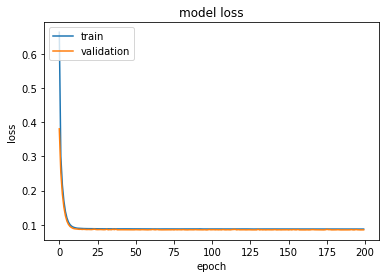

In [20]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
from tensorflow.keras import backend as K
def evaluate_nn(X,Y):
    #evaluate on test dataset
    Y_preds = model.predict(X)
    # R2 = model.score(X_tests, Y_tests)
    RMSE = np.sqrt(metrics.mean_squared_error(Y, Y_preds))
    test_loss = model.evaluate(X, Y)
    return RMSE, test_loss
RMSE, test_loss = evaluate_nn(X_test,Y_test)
print(RMSE)


217/217 [==============================] - 0s 365us/step - loss: 0.0842 - mse: 0.0842 - mae: 0.2255
0.2901685
